In [44]:
import os

def count_videos(root_dir):
    total = 0
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        # Count subdirectories (each subdirectory is a video folder)
        num_videos = sum(
            1 for sub in os.listdir(cls_path)
            if os.path.isdir(os.path.join(cls_path, sub))
        )
        print(f"{cls}: {num_videos} videos")
        total += num_videos
    return total

train_root = r"C:\Users\rayaa\Downloads\ucf_crime\Train"
test_root = r"C:\Users\rayaa\Downloads\ucf_crime\Test"

train_count = count_videos(train_root)
test_count = count_videos(test_root)

print(f"\nTotal Train videos: {train_count}")
print(f"Total Test videos: {test_count}")


Abuse: 48 videos
Arrest: 45 videos
Arson: 41 videos
Assault: 47 videos
Burglary: 87 videos
Explosion: 29 videos
Fighting: 45 videos
NormalVideos: 800 videos
RoadAccidents: 127 videos
Robbery: 145 videos
Shooting: 27 videos
Shoplifting: 29 videos
Stealing: 95 videos
Vandalism: 45 videos
Abuse: 2 videos
Arrest: 5 videos
Arson: 9 videos
Assault: 3 videos
Burglary: 13 videos
Explosion: 21 videos
Fighting: 5 videos
NormalVideos: 150 videos
RoadAccidents: 23 videos
Robbery: 5 videos
Shooting: 23 videos
Shoplifting: 21 videos
Stealing: 5 videos
Vandalism: 5 videos

Total Train videos: 1610
Total Test videos: 290


In [ ]:
# ============================================
# Imports
# ============================================
import os, glob, random, torch, shutil
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torch.optim import AdamW
from transformers import AutoImageProcessor, VideoMAEForVideoClassification
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ============================================
# Dataset Definition (with optional downsampling)
# ============================================
class UCFCrimeClipDataset(Dataset):
    def __init__(self, root_dir, clip_len=16, image_processor=None, downsample_normal=None):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.image_processor = image_processor
        self.samples = []

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}

        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            video_folders = [vf for vf in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path, vf))]

            # Downsample NormalVideos if requested
            if downsample_normal is not None and "Normal" in cls:
                video_folders = random.sample(video_folders, min(downsample_normal, len(video_folders)))

            for video_folder in video_folders:
                video_path = os.path.join(cls_path, video_folder)
                self.samples.append((video_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = sorted(glob.glob(os.path.join(video_path, "*.png")))
        if len(frames) == 0:
            raise RuntimeError(f"No frames found in {video_path}")

        # Sample clip_len frames (random or pad)
        if len(frames) >= self.clip_len:
            indices = sorted(random.sample(range(len(frames)), self.clip_len))
        else:
            indices = list(range(len(frames))) + [len(frames) - 1] * (self.clip_len - len(frames))

        clip = [Image.open(frames[i]).convert("RGB") for i in indices]
        pixel_values = self.image_processor(clip, return_tensors="pt")["pixel_values"]
        pixel_values = pixel_values.squeeze(0)  # [C, T, H, W]
        return pixel_values, label

# ============================================
# Paths & Setup
# ============================================
train_root = r"C:\Users\rayaa\Downloads\ucf_crime\Train"
test_root = r"C:\Users\rayaa\Downloads\ucf_crime\Test"
num_classes = len(os.listdir(train_root))

base_model_name = "MCG-NJU/videomae-base"
image_processor = AutoImageProcessor.from_pretrained(base_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# Model
# ============================================
model = VideoMAEForVideoClassification.from_pretrained(
    base_model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# ============================================
# Datasets + DataLoaders
# ============================================
# Downsample NormalVideos to 150
train_dataset = UCFCrimeClipDataset(train_root, clip_len=16, image_processor=image_processor, downsample_normal=150)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = UCFCrimeClipDataset(test_root, clip_len=16, image_processor=image_processor)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ============================================
# Training Loop with Checkpointing
# ============================================
checkpoint_dir = r"C:\Users\rayaa\Downloads\ucf_crime\checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

epochs = 100
save_every = 2  # save checkpoint every N epochs

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for clips, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        clips, labels = clips.to(device).float(), labels.to(device)
        outputs = model(pixel_values=clips)
        logits = outputs.logits
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, preds = logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/total:.4f} - Acc: {correct/total:.4f}")

    # Checkpoint
    if (epoch + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"💾 Saved checkpoint: {checkpoint_path}")

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train samples: 960, Test samples: 290


Epoch 1/100: 100%|██████████| 480/480 [18:57<00:00,  2.37s/it]


Epoch [1/100] - Loss: 2.4865 - Acc: 0.1740


Epoch 2/100: 100%|██████████| 480/480 [20:03<00:00,  2.51s/it]


Epoch [2/100] - Loss: 2.3221 - Acc: 0.2219
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_2.pt


Epoch 3/100: 100%|██████████| 480/480 [20:21<00:00,  2.55s/it]


Epoch [3/100] - Loss: 2.1246 - Acc: 0.2865


Epoch 4/100: 100%|██████████| 480/480 [19:59<00:00,  2.50s/it]


Epoch [4/100] - Loss: 1.8971 - Acc: 0.3927
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_4.pt


Epoch 5/100: 100%|██████████| 480/480 [20:20<00:00,  2.54s/it]


Epoch [5/100] - Loss: 1.6636 - Acc: 0.4635


Epoch 6/100: 100%|██████████| 480/480 [20:15<00:00,  2.53s/it]


Epoch [6/100] - Loss: 1.3612 - Acc: 0.5667
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_6.pt


Epoch 7/100: 100%|██████████| 480/480 [19:46<00:00,  2.47s/it]


Epoch [7/100] - Loss: 0.9989 - Acc: 0.6802


Epoch 8/100: 100%|██████████| 480/480 [19:57<00:00,  2.50s/it]


Epoch [8/100] - Loss: 0.7736 - Acc: 0.7479
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_8.pt


Epoch 9/100: 100%|██████████| 480/480 [20:00<00:00,  2.50s/it]


Epoch [9/100] - Loss: 0.5023 - Acc: 0.8583


Epoch 10/100: 100%|██████████| 480/480 [19:33<00:00,  2.44s/it]


Epoch [10/100] - Loss: 0.3581 - Acc: 0.8979
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_10.pt


Epoch 11/100: 100%|██████████| 480/480 [19:34<00:00,  2.45s/it]


Epoch [11/100] - Loss: 0.2694 - Acc: 0.9198


Epoch 12/100: 100%|██████████| 480/480 [19:41<00:00,  2.46s/it]


Epoch [12/100] - Loss: 0.2316 - Acc: 0.9313
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_12.pt


Epoch 13/100: 100%|██████████| 480/480 [19:40<00:00,  2.46s/it]


Epoch [13/100] - Loss: 0.1597 - Acc: 0.9594


Epoch 14/100: 100%|██████████| 480/480 [19:29<00:00,  2.44s/it]


Epoch [14/100] - Loss: 0.1381 - Acc: 0.9615
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_14.pt


Epoch 15/100: 100%|██████████| 480/480 [18:59<00:00,  2.37s/it]


Epoch [15/100] - Loss: 0.2308 - Acc: 0.9281


Epoch 16/100: 100%|██████████| 480/480 [19:10<00:00,  2.40s/it]


Epoch [16/100] - Loss: 0.1608 - Acc: 0.9552
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_16.pt


Epoch 17/100: 100%|██████████| 480/480 [18:52<00:00,  2.36s/it]


Epoch [17/100] - Loss: 0.2339 - Acc: 0.9260


Epoch 18/100: 100%|██████████| 480/480 [18:45<00:00,  2.34s/it]


Epoch [18/100] - Loss: 0.1248 - Acc: 0.9615
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_18.pt


Epoch 19/100: 100%|██████████| 480/480 [19:06<00:00,  2.39s/it]


Epoch [19/100] - Loss: 0.1234 - Acc: 0.9573


Epoch 20/100: 100%|██████████| 480/480 [18:56<00:00,  2.37s/it]


Epoch [20/100] - Loss: 0.1300 - Acc: 0.9625
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_20.pt


Epoch 21/100: 100%|██████████| 480/480 [18:45<00:00,  2.34s/it]


Epoch [21/100] - Loss: 0.1276 - Acc: 0.9635


Epoch 22/100: 100%|██████████| 480/480 [18:39<00:00,  2.33s/it]


Epoch [22/100] - Loss: 0.1163 - Acc: 0.9646
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_22.pt


Epoch 23/100: 100%|██████████| 480/480 [19:05<00:00,  2.39s/it]


Epoch [23/100] - Loss: 0.1204 - Acc: 0.9646


Epoch 24/100: 100%|██████████| 480/480 [18:50<00:00,  2.36s/it]


Epoch [24/100] - Loss: 0.1249 - Acc: 0.9688
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_24.pt


Epoch 25/100: 100%|██████████| 480/480 [18:55<00:00,  2.37s/it]


Epoch [25/100] - Loss: 0.1700 - Acc: 0.9469


Epoch 26/100: 100%|██████████| 480/480 [19:07<00:00,  2.39s/it]


Epoch [26/100] - Loss: 0.1307 - Acc: 0.9583
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_26.pt


Epoch 27/100: 100%|██████████| 480/480 [18:23<00:00,  2.30s/it]


Epoch [27/100] - Loss: 0.1349 - Acc: 0.9552


Epoch 28/100: 100%|██████████| 480/480 [17:06<00:00,  2.14s/it]


Epoch [28/100] - Loss: 0.0433 - Acc: 0.9896
💾 Saved checkpoint: C:\Users\rayaa\Downloads\ucf_crime\checkpoints\epoch_28.pt


Epoch 29/100:  27%|██▋       | 131/480 [04:40<12:27,  2.14s/it]


KeyboardInterrupt: 

Evaluating: 100%|██████████| 145/145 [02:37<00:00,  1.09s/it]


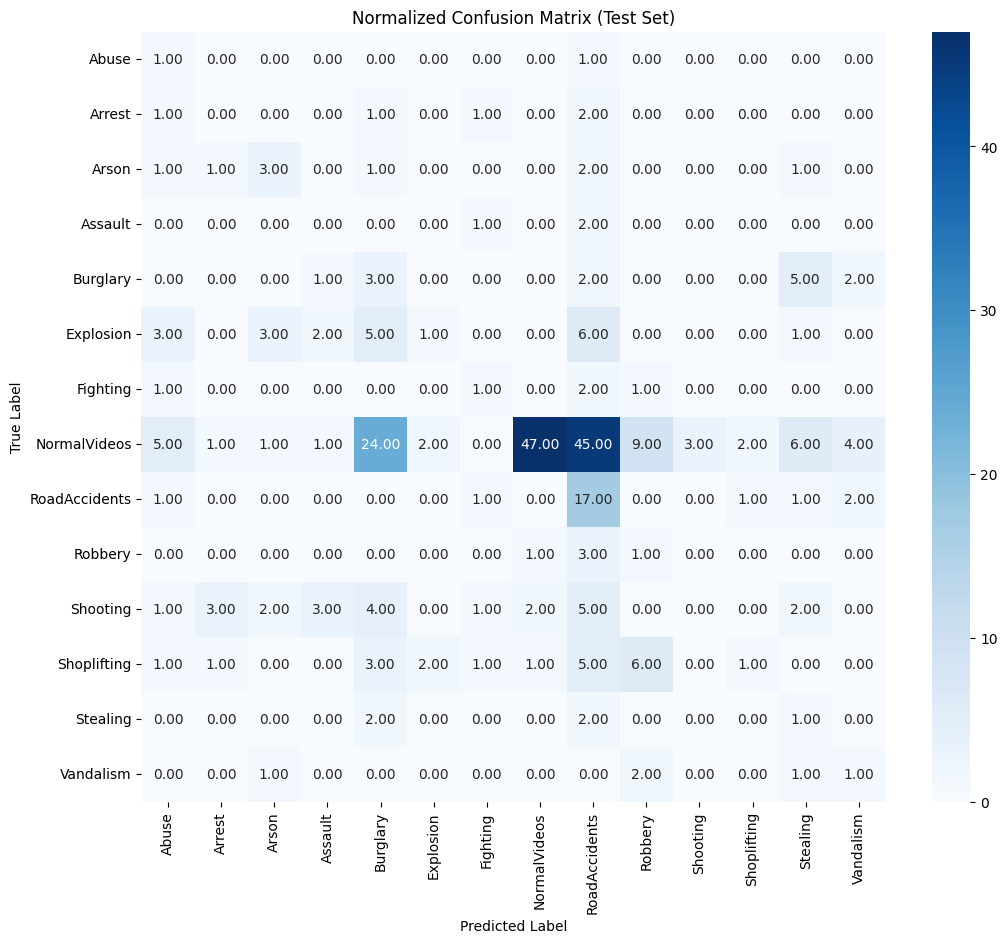


Classification Report (Test Set):
               precision    recall  f1-score   support

        Abuse       0.07      0.50      0.12         2
       Arrest       0.00      0.00      0.00         5
        Arson       0.30      0.33      0.32         9
      Assault       0.00      0.00      0.00         3
     Burglary       0.07      0.23      0.11        13
    Explosion       0.20      0.05      0.08        21
     Fighting       0.17      0.20      0.18         5
 NormalVideos       0.92      0.31      0.47       150
RoadAccidents       0.18      0.74      0.29        23
      Robbery       0.05      0.20      0.08         5
     Shooting       0.00      0.00      0.00        23
  Shoplifting       0.25      0.05      0.08        21
     Stealing       0.06      0.20      0.09         5
    Vandalism       0.11      0.20      0.14         5

     accuracy                           0.27       290
    macro avg       0.17      0.22      0.14       290
 weighted avg       0.54    

In [47]:
# ============================================
# Evaluation
# ============================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for clips, labels in tqdm(test_loader, desc="Evaluating"):
        clips, labels = clips.to(device).float(), labels.to(device)
        outputs = model(pixel_values=clips)
        preds = outputs.logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

labels_arr = np.arange(num_classes)
class_names = [cls for cls, _ in sorted(test_dataset.class_to_idx.items(), key=lambda x: x[1])]

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=labels_arr)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Test Set)")
plt.show()

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds, labels=labels_arr, target_names=class_names))

# Overall accuracy
acc = np.trace(cm) / np.sum(cm)
print(f"Overall Test Accuracy: {acc:.4f}")
